# Stat 538 Homework 1 Programming Exercise: Training Neural Networks with Different Optimizers
## Statistical Learning - Winter 2026

### Objectives
In this exercise, you will:
1. Implement a fully-connected neural network using PyTorch's `nn.Module`
2. Implement custom optimization algorithms from scratch
3. Implement a training loop that works with both custom and PyTorch optimizers
4. Compare different optimizers and explore regularization techniques

### What's Provided (from part 4)
- Data loading and preprocessing utilities
- Testing your implementations
- Plotting and visualization functions
- Helper utilities for tracking metrics

### What You Need to Implement
- Neural network architecture
- Custom optimization algorithms
- Training loop

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

# Set random seeds for reproducibility
torch.manual_seed(123)
np.random.seed(123)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Part 1: Define Neural Network Architecture using PyTorch

**TODO**: Implement a fully-connected neural network class that inherits from `nn.Module`, with the options of batch norm and dropout.

**Requirements**:
1. The `__init__` method should:
   - Accept `input_dim`, `hidden_dims` (list), `output_dim`, `activation` type
   - Optionally support `use_batch_norm` and `dropout_rate`
   - Build layers using `nn.Linear`
   - Store layers in `nn.ModuleList`
   - Initialize weights appropriately (He init for ReLU, Xavier for others)

2. The `forward` method should:
   - Pass input through all hidden layers with activation functions
   - Apply batch normalization and dropout if specified
   - Return output from final layer (no activation)

3. Include a `count_parameters()` method to count trainable parameters

**Hints**:
- Use `nn.ModuleList` to store layers (not regular Python list)
- Batch norm should be applied after linear layer but before activation
- Dropout should be applied after activation

In [2]:
class FullyConnectedNet(nn.Module):
    """Fully-connected neural network"""

    def __init__(self, input_dim, hidden_dims, output_dim, activation='relu',
                 use_batch_norm=False, dropout_rate=0.0):
        """
        Args:
            input_dim: Input feature dimension
            hidden_dims: List of hidden layer dimensions (e.g., [64, 32])
            output_dim: Output dimension (number of classes)
            activation: Activation function ('relu', 'tanh', 'sigmoid')
            use_batch_norm: Whether to use batch normalization
            dropout_rate: Dropout probability (0 = no dropout)
        """
        super(FullyConnectedNet, self).__init__()

        # TODO: Store configuration
        # Your code here
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate

        # TODO: Choose activation function
        # Hint: Use nn.ReLU(), nn.Tanh(), or nn.Sigmoid()
        # Your code here
        self.activation = nn.ReLU()

        # TODO: Build layers
        # Hint: Create lists for layers, batch_norms, and dropouts
        # Hint: Loop through hidden_dims and create nn.Linear layers
        # Hint: Don't forget to track prev_dim for connecting layers
        # Your code here
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, output_dim))

        # TODO: Register layers as ModuleLists
        # Hint: self.layers = nn.ModuleList(layers)
        # Your code here
        self.layers = nn.ModuleList(layers)
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(dim) for dim in hidden_dims]) if use_batch_norm else nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None

        # TODO: Initialize weights
        # Your code here
        for layer in self.layers:
            nn.init.kaiming_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)
        pass

    def forward(self, x):
        """Forward pass through the network"""
        # TODO: Pass input through hidden layers
        # For each hidden layer:
        #   1. Apply linear transformation
        #   2. Apply batch normalization (if enabled)
        #   3. Apply activation function
        #   4. Apply dropout (if enabled)
        # Your code here
        for idx, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if self.use_batch_norm:
                x = self.batch_norms[idx](x)
            x = self.activation(x)
            if self.dropout is not None:
                x = self.dropout(x)

        # TODO: Apply final output layer (no activation)
        # Your code here
        x = self.layers[-1](x)
        return x

    def count_parameters(self):
        """Count total number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Test the network
test_net = FullyConnectedNet(input_dim=2, hidden_dims=[32, 16], output_dim=2)
print(f"Network architecture:\n{test_net}")
print(f"\nTotal parameters: {test_net.count_parameters()}")

# Test forward pass
test_input = torch.randn(5, 2)
test_output = test_net(test_input)
print(f"\nInput shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output (should be 5x2): {test_output.shape}")

Network architecture:
FullyConnectedNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
  (batch_norms): ModuleList()
)

Total parameters: 658

Input shape: torch.Size([5, 2])
Output shape: torch.Size([5, 2])
Output (should be 5x2): torch.Size([5, 2])


## Part 2: Custom Optimizer Implementations

**TODO**: Implement custom optimization algorithms from scratch.

All optimizers should inherit from `CustomOptimizer` base class and implement the `step()` method.

### 2.1 Base Optimizer Class (Provided)

In [3]:
class CustomOptimizer:
    """Base class for custom optimizers"""

    def __init__(self, parameters, lr=0.01):
        """
        Args:
            parameters: Iterable of parameters to optimize (from model.parameters())
            lr: Learning rate
        """
        self.parameters = list(parameters)
        self.lr = lr

    def zero_grad(self):
        """Zero out gradients (like PyTorch optimizers)"""
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

    def step(self):
        """Update parameters - to be implemented by subclasses"""
        raise NotImplementedError

### 2.2 Gradient Descent

**TODO**: Implement vanilla gradient descent.

**Algorithm**: $\theta_{t+1} = \theta_t - \eta \nabla f(\theta_t)$

**Hints**:
- Use `@torch.no_grad()` decorator to disable gradient tracking
- Parameters values are in `param.data`, gradients in `param.grad`
- Check if `param.grad is None` before updating

In [4]:
class CustomGradientDescent(CustomOptimizer):
    """
    Gradient Descent: θ_{t+1} = θ_t - η∇f(θ_t)
    """

    def __init__(self, parameters, lr=0.01):
        super().__init__(parameters, lr)

    @torch.no_grad()
    def step(self):
        """Perform a single optimization step"""
        # TODO: Loop through parameters and update each one
        # For each parameter, apply the update rule: θ = θ - lr * grad
        # Your code here
        for param in self.parameters:
            if param.grad is not None:
                param.data -= self.lr * param.grad  
        pass

### 2.3 SGD with Momentum

**TODO**: Implement SGD with momentum.

**Algorithm**:
- $v_t = \beta v_{t-1} + \nabla f(\theta_t)$
- $\theta_{t+1} = \theta_t - \eta v_t$

**Hints**:
- Initialize velocity vectors in `__init__` as list of zeros (same shape as parameters)
- In `step()`: first update velocity, then update parameters using velocity

In [5]:
class CustomSGDMomentum(CustomOptimizer):
    """
    SGD with Momentum:
    v_t = β*v_{t-1} + ∇f(θ_t)
    θ_{t+1} = θ_t - η*v_t
    """

    def __init__(self, parameters, lr=0.01, momentum=0.9):
        super().__init__(parameters, lr)
        self.momentum = momentum

        # TODO: Initialize velocity for each parameter
        # Hint: Create a list of zero tensors with same shape as parameters
        # Hint: self.velocity = [torch.zeros_like(p.data) for p in self.parameters]
        # Your code here
        self.velocity = [torch.zeros_like(p.data) for p in self.parameters]

    @torch.no_grad()
    def step(self):
        """Perform a single optimization step with momentum"""
        # TODO: For each parameter:
        #   1. Update velocity: v = β*v + grad
        #   2. Update parameter: θ = θ - lr * v
        # Your code here
        for i, param in enumerate(self.parameters):
            if param.grad is not None:
                self.velocity[i] = self.momentum * self.velocity[i] + param.grad
                param.data -= self.lr * self.velocity[i]
        pass

### 2.4 Adam Optimizer

**TODO**: Implement the Adam optimizer.

**Algorithm**:
- $m_t = \beta_1 m_{t-1} + (1-\beta_1)\nabla f(\theta_t)$ (first moment)
- $v_t = \beta_2 v_{t-1} + (1-\beta_2)(\nabla f(\theta_t))^2$ (second moment)
- $\hat{m}_t = m_t / (1 - \beta_1^t)$ (bias correction)
- $\hat{v}_t = v_t / (1 - \beta_2^t)$ (bias correction)
- $\theta_{t+1} = \theta_t - \eta \hat{m}_t / (\sqrt{\hat{v}_t} + \epsilon)$

**Hints**:
- Initialize `self.m` and `self.v` as lists of zero tensors
- Track time step `self.t` (increment in `step()`)
- For element-wise operations, use `*` for multiplication
- Use `torch.sqrt()` for square root

In [6]:
class CustomAdam(CustomOptimizer):
    """
    Adam Optimizer (Adaptive Moment Estimation):
    Combines momentum and adaptive learning rates with bias correction
    """

    def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(parameters, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        # TODO: Initialize first moment (m), second moment (v), and time step (t)
        # Hint: Create lists of zero tensors and initialize time step to 0
        # self.m = [torch.zeros_like(p.data) for p in self.parameters]
        # Your code here
        self.m = [torch.zeros_like(p.data) for p in self.parameters]
        self.v = [torch.zeros_like(p.data) for p in self.parameters]
        self.t = 0


    @torch.no_grad()
    def step(self):
        """Perform a single optimization step with Adam"""
        # TODO: Implement Adam optimizer following the algorithm above
        # Remember to:
        #   1. Increment time step
        #   2. Update first and second moments
        #   3. Compute bias-corrected moments
        #   4. Update parameters
        # Your code here
        self.t += 1
        for i, param in enumerate(self.parameters):
            if param.grad is not None:
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * param.grad ** 2
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                param.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)
        pass


print("TODO: Implement the optimizer classes above!")
print("Once implemented, you should see:")
print("- CustomGradientDescent")
print("- CustomSGDMomentum")
print("- CustomAdam")

TODO: Implement the optimizer classes above!
Once implemented, you should see:
- CustomGradientDescent
- CustomSGDMomentum
- CustomAdam


## Part 3: Training Loop

**TODO**: Implement the training loop that works with your custom optimizers.

**Requirements**:
1. The function should handle both training and validation phases
2. Track metrics (loss and accuracy) for both phases
3. Support learning rate scheduling
4. Return a history dictionary with all metrics

**Training phase steps**:
- Set model to training mode
- Loop through batches: forward pass → compute loss → backward pass → optimizer step
- Track training loss and accuracy

**Validation phase steps**:
- Set model to evaluation mode
- Disable gradient computation
- Loop through batches: forward pass → compute loss
- Track validation loss and accuracy

In [7]:
def train_model(model, train_loader, val_loader, optimizer, criterion,
                epochs=100, device='cpu', verbose=True, scheduler=None):
    """
    Train a PyTorch model with a custom optimizer.

    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        optimizer: Custom optimizer instance
        criterion: Loss function (e.g., nn.CrossEntropyLoss())
        epochs: Number of training epochs
        device: Device to train on ('cpu' or 'cuda')
        verbose: Whether to print progress
        scheduler: Optional learning rate scheduler

    Returns:
        Dictionary with training history containing:
        - 'train_loss': list of training losses per epoch
        - 'train_acc': list of training accuracies per epoch
        - 'val_loss': list of validation losses per epoch
        - 'val_acc': list of validation accuracies per epoch
        - 'lr': list of learning rates per epoch
    """
    model = model.to(device)

    # Initialize history dictionary
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    for epoch in range(epochs):
        # ==================== TRAINING PHASE ====================
        # TODO: Set model to training mode
        # Hint: model.train()
        # Your code here
        model.train()

        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # TODO: Loop through training batches
        # For each batch:
        #   1. Move batch to device
        #   2. Zero gradients
        #   3. Forward pass
        #   4. Compute loss
        #   5. Backward pass
        #   6. Update parameters
        #   7. Track metrics (loss and accuracy)
        # Hint: Use optimizer.zero_grad(), loss.backward(), optimizer.step()
        # Hint: Get predictions with _, predicted = torch.max(outputs.data, 1)
        # Your code here
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item() * batch_y.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        # TODO: Compute average training loss and accuracy
        # Hint: train_loss /= train_total
        # Hint: train_acc = train_correct / train_total
        # Your code here
        train_loss /= train_total
        train_acc = train_correct / train_total

        # ==================== VALIDATION PHASE ====================
        # TODO: Set model to evaluation mode
        # Hint: model.eval()
        # Your code here
        model.eval()

        val_loss = 0.0
        val_correct = 0
        val_total = 0

        # TODO: Disable gradient computation and loop through validation batches
        # Hint: Use 'with torch.no_grad():' context manager
        # For each batch:
        #   1. Move batch to device
        #   2. Forward pass (no backward pass needed)
        #   3. Compute loss
        #   4. Track metrics
        # Your code here
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            with torch.no_grad():
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
                val_loss += loss.item() * batch_y.size(0)

        # TODO: Compute average validation loss and accuracy
        # Your code here
        val_loss /= val_total
        val_acc = val_correct / val_total

        # ==================== STORE METRICS ====================
        # TODO: Append metrics to history lists
        # Hint: history['train_loss'].append(train_loss)
        # Your code here
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Get current learning rate
        current_lr = optimizer.lr if hasattr(optimizer, 'lr') else optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)

        # Update learning rate scheduler if provided
        if scheduler is not None:
            scheduler.step()

        # Print progress
        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
                  f"LR: {current_lr:.6f}")

    return history


print("TODO: Implement the train_model function above!")

TODO: Implement the train_model function above!


## Part 4: Visualization and Data Utilities (Provided)

These utility functions are provided to help you visualize and analyze your models:
- `plot_training_curves()`: Visualize training/validation metrics across epochs
- `plot_decision_boundary()`: Visualize the decision boundary for 2D classification
- `prepare_dataset()`: Load and preprocess datasets

In [8]:
def plot_training_curves(histories, labels, figsize=(15, 5)):
    """Plot training curves for multiple models."""
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Plot loss
    for history, label in zip(histories, labels):
        axes[0].plot(history['train_loss'], label=f'{label} (train)', linestyle='--', alpha=0.7)
        axes[0].plot(history['val_loss'], label=f'{label} (val)', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=13)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot accuracy
    for history, label in zip(histories, labels):
        axes[1].plot(history['train_acc'], label=f'{label} (train)', linestyle='--', alpha=0.7)
        axes[1].plot(history['val_acc'], label=f'{label} (val)', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=13)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Plot learning rate
    for history, label in zip(histories, labels):
        if 'lr' in history and len(history['lr']) > 0:
            axes[2].plot(history['lr'], label=label, linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Learning Rate', fontsize=12)
    axes[2].set_title('Learning Rate Schedule', fontsize=13)
    axes[2].set_yscale('log')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_decision_boundary(model, X, y, title='Decision Boundary', device='cpu'):
    """Plot decision boundary for 2D classification."""
    model.eval()

    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    X_grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    with torch.no_grad():
        Z = model(X_grid)
        Z = torch.argmax(Z, dim=1).cpu().numpy()
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', s=50, alpha=0.7)
    plt.title(title, fontsize=14)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.colorbar(label='Class')
    plt.grid(True, alpha=0.3)
    plt.show()


def prepare_dataset(dataset_type='moons', n_samples=1000, noise=0.2, test_size=0.2, val_size=0.25, random_state=123):
    """Prepare dataset for classification."""
    # Generate data
    if dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    elif dataset_type == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=noise, random_state=random_state)
    elif dataset_type == 'classification':
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
                                   n_informative=2, n_clusters_per_class=1,
                                   random_state=random_state)
    else:
        raise ValueError(f"Unknown dataset type: {dataset_type}")

    # Split data using stratified splits
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size,
                                                       random_state=random_state, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size,
                                                       random_state=random_state, stratify=y_temp)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return (train_loader, val_loader, test_loader,
            (X_train, y_train), (X_val, y_val), (X_test, y_test))


print("Visualization utilities ready!")

Visualization utilities ready!


## Part 5: Prepare and Visualize Data

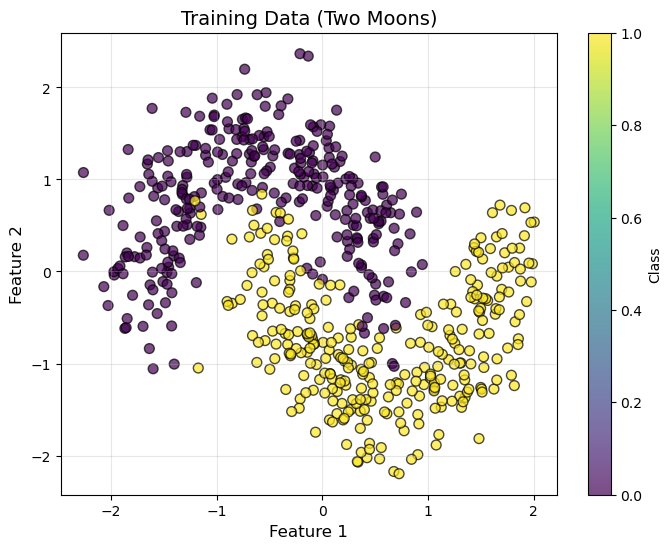

Training samples: 600
Validation samples: 200
Test samples: 200


In [9]:
# Prepare dataset
train_loader, val_loader, test_loader, (X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    prepare_dataset(dataset_type='moons', n_samples=1000, noise=0.2, random_state=123)

# Visualize data
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis',
           edgecolors='k', s=50, alpha=0.7)
plt.title('Training Data (Two Moons)', fontsize=14)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.colorbar(label='Class')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

## Part 6: Test Your Implementation

Once you've implemented all the TODOs above, run this cell to test your implementation.

Testing your implementations...

Model parameters: 202

Training for 20 epochs...
Epoch [10/20] - Train Loss: 0.1269, Train Acc: 0.9450, Val Loss: 0.2455, Val Acc: 0.9000, LR: 0.010000
Epoch [20/20] - Train Loss: 0.0722, Train Acc: 0.9717, Val Loss: 0.2271, Val Acc: 0.9400, LR: 0.010000


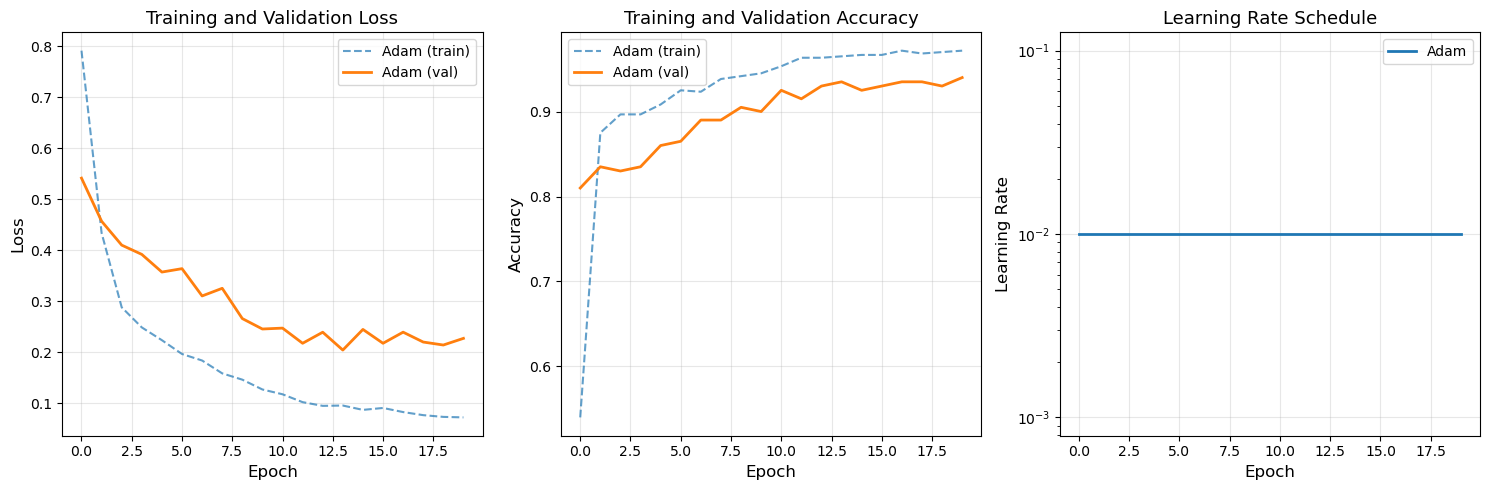

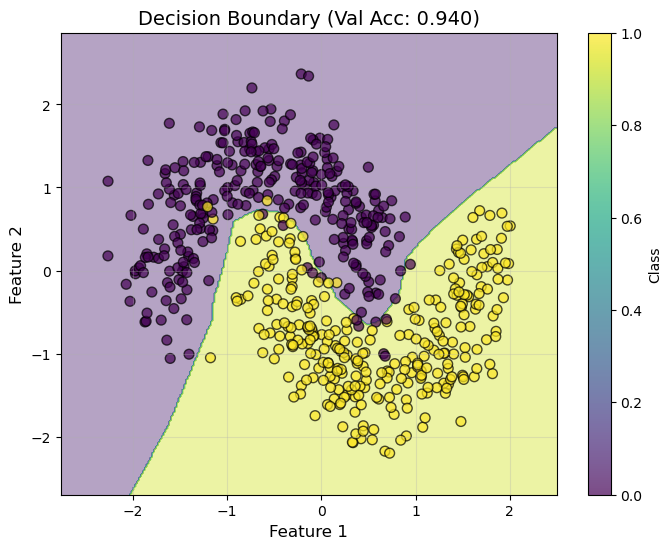


If you see plots above, congratulations! Your implementation works!
Final validation accuracy: 0.9400


In [10]:
# Test your implementations
print("Testing your implementations...\n")

# Create a simple model
model = FullyConnectedNet(input_dim=2, hidden_dims=[16, 8], output_dim=2)
print(f"Model parameters: {model.count_parameters()}")

# Create optimizer and loss function
optimizer = CustomAdam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train for a few epochs
print("\nTraining for 20 epochs...")
history = train_model(model, train_loader, val_loader, optimizer, criterion,
                     epochs=20, device=device, verbose=True)

# Plot results
plot_training_curves([history], ['Adam'], figsize=(15, 5))

# Plot decision boundary
plot_decision_boundary(model, X_train, y_train,
                      title=f'Decision Boundary (Val Acc: {history["val_acc"][-1]:.3f})',
                      device=device)

print("\nIf you see plots above, congratulations! Your implementation works!")
print(f"Final validation accuracy: {history['val_acc'][-1]:.4f}")

## Part 7: Compare Optimizers

Now that you have working implementations, try comparing different optimizers!

Comparing optimizers...

Training with GD...
  Final val acc: 0.9300
Training with Momentum...
  Final val acc: 0.9350
Training with Adam...
  Final val acc: 0.9350


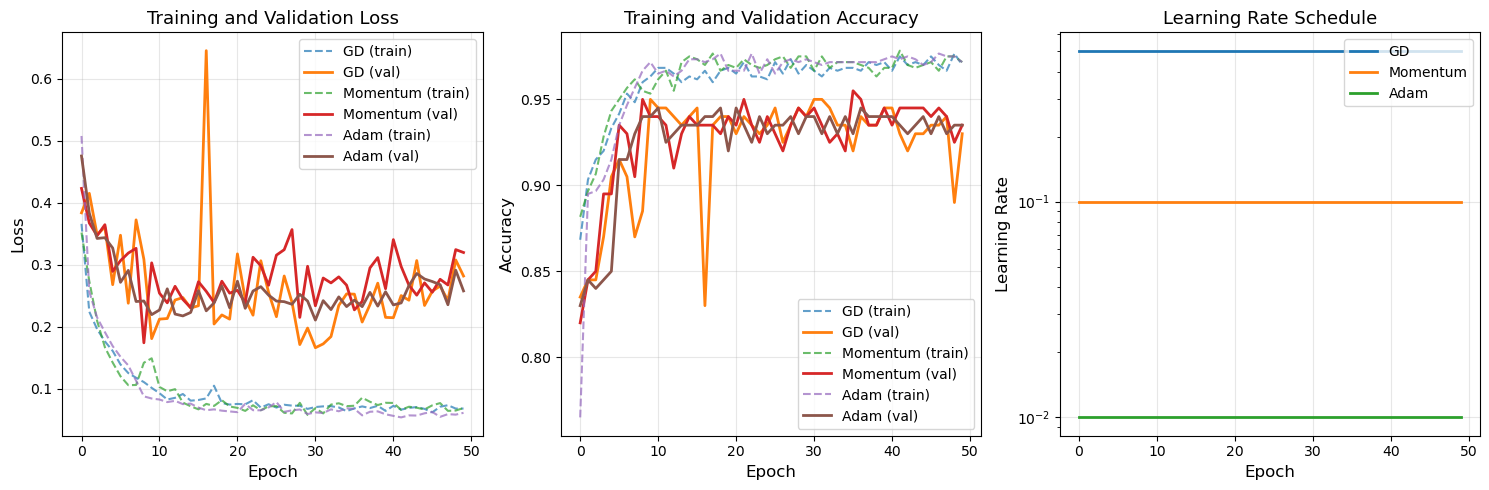


Comparison complete!


In [11]:
# Compare different optimizers
print("Comparing optimizers...\n")

optimizer_configs = {
    'GD': (CustomGradientDescent, {'lr': 0.5}),
    'Momentum': (CustomSGDMomentum, {'lr': 0.1, 'momentum': 0.9}),
    'Adam': (CustomAdam, {'lr': 0.01})
}

results = {}
for name, (opt_class, params) in optimizer_configs.items():
    print(f"Training with {name}...")

    # Create fresh model
    model = FullyConnectedNet(input_dim=2, hidden_dims=[32, 16], output_dim=2)
    optimizer = opt_class(model.parameters(), **params)

    # Train
    history = train_model(model, train_loader, val_loader, optimizer, criterion,
                         epochs=50, device=device, verbose=False)

    results[name] = history
    print(f"  Final val acc: {history['val_acc'][-1]:.4f}")

# Plot comparison
plot_training_curves(
    [results[name] for name in optimizer_configs.keys()],
    list(optimizer_configs.keys())
)

print("\nComparison complete!")

## Part 8: Effect of Regularization

Explore how different regularization techniques interact with optimization algorithms.

The `FullyConnectedNet` class supports:
- Batch normalization: `use_batch_norm=True`
- Dropout: `dropout_rate=0.3` (typically 0.2-0.5)

Try training models with different combinations and observe:
- Training vs validation accuracy gap (overfitting indicator)
- Convergence speed
- Final performance

Experiment: Regularization with Custom Optimizers

Training with No Reg...
  Final train acc: 0.9783
  Final val acc: 0.9500
  Train-val gap: 0.0283

Training with Dropout...


  Final train acc: 0.9750
  Final val acc: 0.9650
  Train-val gap: 0.0100

Training with BatchNorm...
  Final train acc: 0.9533
  Final val acc: 0.9400
  Train-val gap: 0.0133

Training with Both...
  Final train acc: 0.9650
  Final val acc: 0.9600
  Train-val gap: 0.0050


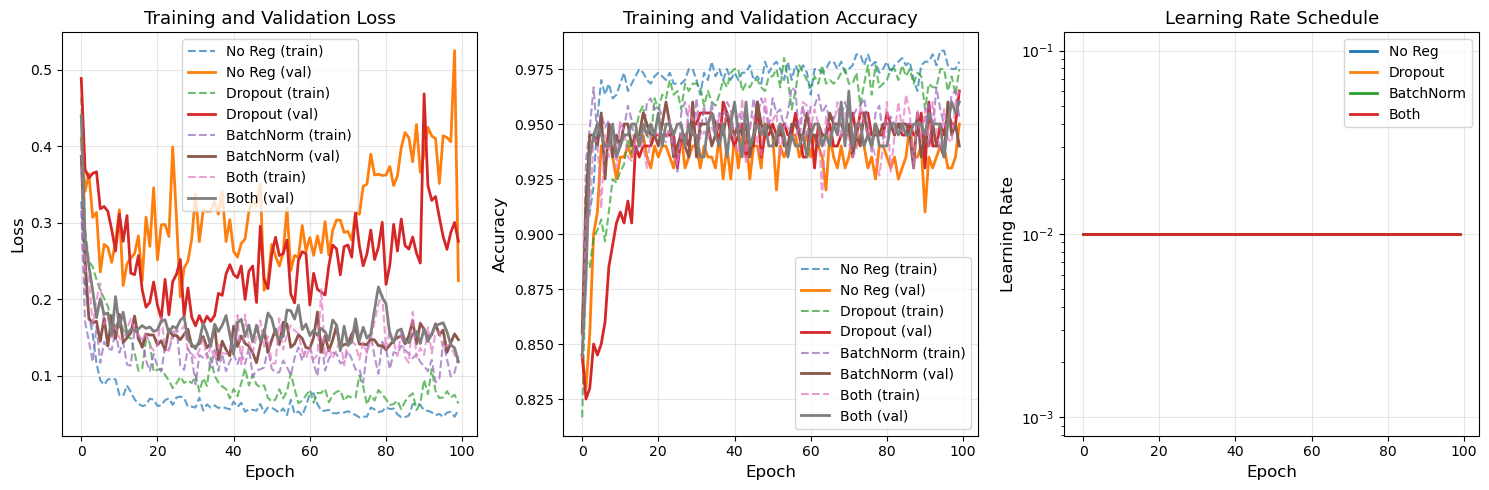


Analysis:
- Dropout reduces overfitting by randomly dropping neurons
- BatchNorm stabilizes training and has regularization effect
- Combining both can work well but may slow convergence
- Watch train-val gap to detect overfitting


In [12]:
print("="*70)
print("Experiment: Regularization with Custom Optimizers")
print("="*70)

# Regularization configurations
reg_configs = {
    'No Reg': {'use_batch_norm': False, 'dropout_rate': 0.0},
    'Dropout': {'use_batch_norm': False, 'dropout_rate': 0.3},
    'BatchNorm': {'use_batch_norm': True, 'dropout_rate': 0.0},
    'Both': {'use_batch_norm': True, 'dropout_rate': 0.2}
}

reg_results = {}

for name, config in reg_configs.items():
    print(f"\nTraining with {name}...")

    # Create model with regularization
    model = FullyConnectedNet(input_dim=2, hidden_dims=[64, 32], output_dim=2,
                             activation='relu', **config)

    # Use Adam optimizer
    optimizer = CustomAdam(model.parameters(), lr=0.01)

    # Train
    history = train_model(model, train_loader, val_loader, optimizer, criterion,
                         epochs=100, device=device, verbose=False)

    reg_results[name] = {
        'model': model,
        'history': history
    }

    # Compute overfitting metric
    train_val_gap = history['train_acc'][-1] - history['val_acc'][-1]

    print(f"  Final train acc: {history['train_acc'][-1]:.4f}")
    print(f"  Final val acc: {history['val_acc'][-1]:.4f}")
    print(f"  Train-val gap: {train_val_gap:.4f}")

# Plot comparison
plot_training_curves(
    [reg_results[name]['history'] for name in reg_configs.keys()],
    list(reg_configs.keys())
)

print("\n" + "="*70)
print("Analysis:")
print("- Dropout reduces overfitting by randomly dropping neurons")
print("- BatchNorm stabilizes training and has regularization effect")
print("- Combining both can work well but may slow convergence")
print("- Watch train-val gap to detect overfitting")
print("="*70)

## Part 9: Compare with PyTorch Built-in Optimizers (Optional Exercise)

Verify that your custom implementations match PyTorch's built-in optimizers.

Try comparing:
- Your `CustomSGDMomentum` with `torch.optim.SGD`
- Your `CustomAdam` with `torch.optim.Adam`

The results should be very similar (though not identical due to random initialization).

Experiment: Custom vs PyTorch Built-in Optimizers

Comparing SGD+Momentum...
  Custom - Final val acc: 0.9300
  Builtin - Final val acc: 0.9450


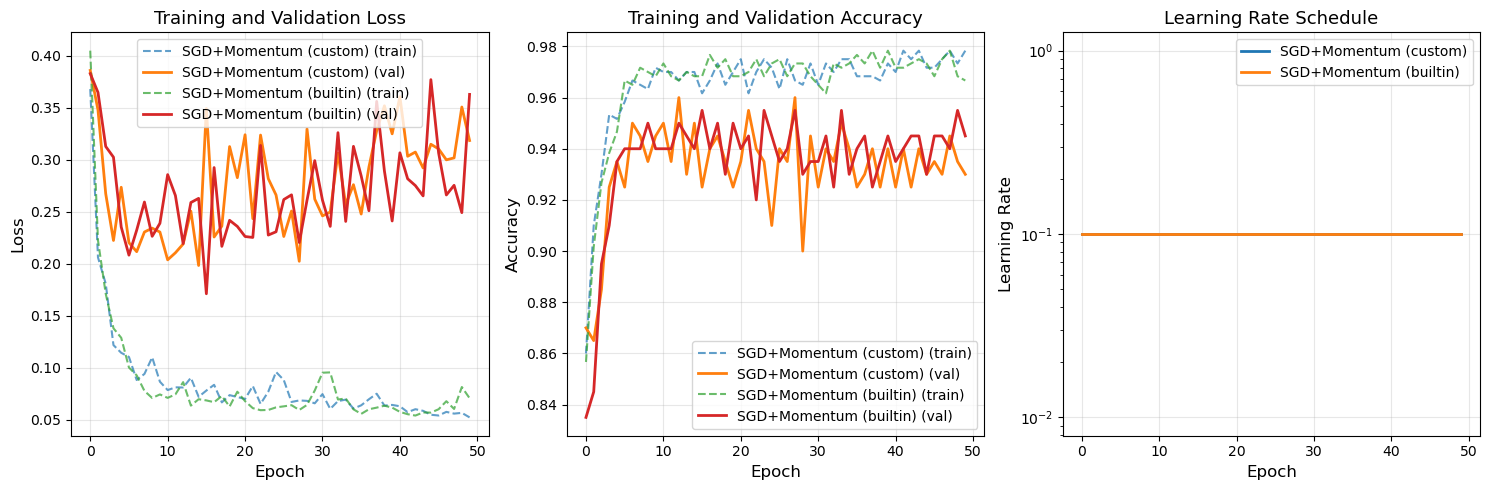


Comparing Adam...
  Custom - Final val acc: 0.9400


  Builtin - Final val acc: 0.9400


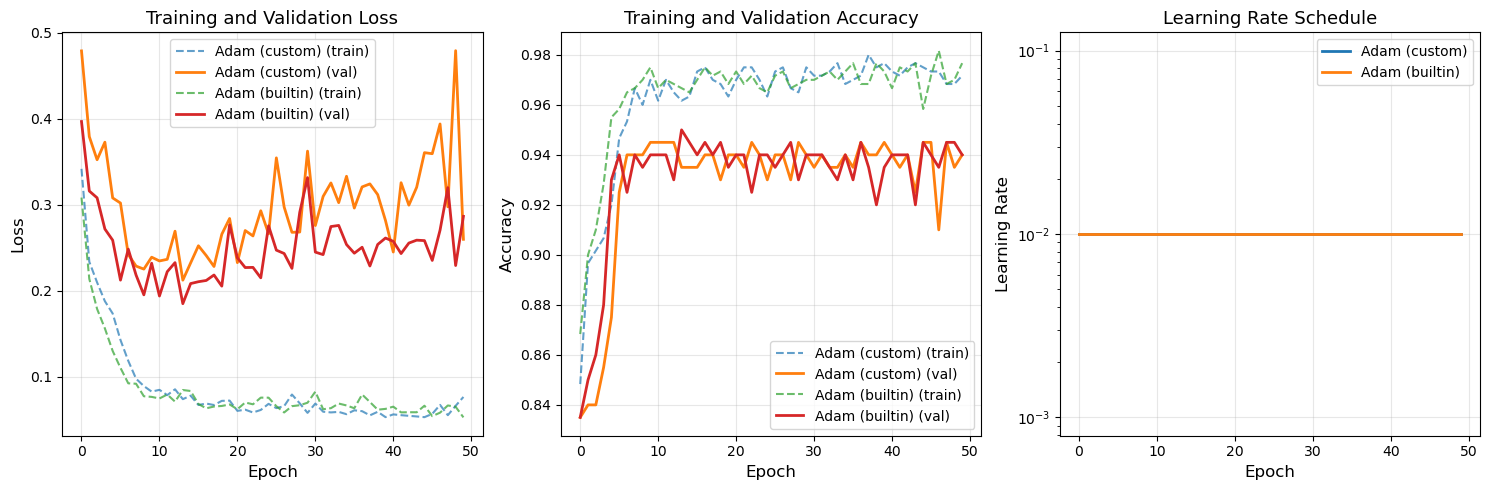


Verification:
Custom implementations should match PyTorch's built-in optimizers closely!
Small differences may occur due to:
  - Different random initializations
  - Numerical precision
  - Implementation details (e.g., momentum formulation)


In [13]:
print("="*70)
print("Experiment: Custom vs PyTorch Built-in Optimizers")
print("="*70)

# Compare custom vs built-in
comparisons = [
    {
        'name': 'SGD+Momentum',
        'custom': CustomSGDMomentum,
        'builtin': torch.optim.SGD,
        'params': {'lr': 0.1, 'momentum': 0.9}
    },
    {
        'name': 'Adam',
        'custom': CustomAdam,
        'builtin': torch.optim.Adam,
        'params': {'lr': 0.01}
    }
]

comparison_results = {}

for comp in comparisons:
    print(f"\nComparing {comp['name']}...")

    histories = []
    labels = []

    for opt_type in ['custom', 'builtin']:
        # Create model
        model = FullyConnectedNet(input_dim=2, hidden_dims=[32, 16], output_dim=2, activation='relu')

        # Create optimizer
        if opt_type == 'custom':
            optimizer = comp['custom'](model.parameters(), **comp['params'])
        else:
            optimizer = comp['builtin'](model.parameters(), **comp['params'])

        # Train
        history = train_model(model, train_loader, val_loader, optimizer, criterion,
                             epochs=50, device=device, verbose=False)

        histories.append(history)
        labels.append(f"{comp['name']} ({opt_type})")

        print(f"  {opt_type.capitalize()} - Final val acc: {history['val_acc'][-1]:.4f}")

    # Plot comparison
    plot_training_curves(histories, labels)

    comparison_results[comp['name']] = histories

print("\n" + "="*70)
print("Verification:")
print("Custom implementations should match PyTorch's built-in optimizers closely!")
print("Small differences may occur due to:")
print("  - Different random initializations")
print("  - Numerical precision")
print("  - Implementation details (e.g., momentum formulation)")
print("="*70)

## Summary

In this exercise, you implemented:

1. **Neural Network Architecture**: A flexible fully-connected network using PyTorch's `nn.Module`
2. **Custom Optimizers**:
   - Gradient Descent
   - SGD with Momentum
   - Adam optimizer
3. **Training Loop**: Complete training and validation procedure

### Key Takeaways:

- **PyTorch handles**: Automatic differentiation, GPU acceleration, efficient tensor operations
- **You implement**: The optimization update rules, giving you full control and understanding
- **Best of both worlds**: Leverage modern tools while understanding the fundamentals